# Example

Say you want to find a protease that cleaves the SARS-CoV2 Spike protein's RBD.

From the protein data bank we can find the Structure of COVID-19 virus spike receptor-binding domain ([7BZ5](https://www.rcsb.org/structure/7BZ5)).

![rbd-im](https://cdn.rcsb.org/images/structures/7bz5_assembly-1.jpeg)

After inspecting the structure we can find several loops that are exposed and available for cleavage, one between positions 334-452, one between 457-472, and one between 474-488.

After finding the suitable sequences we add them to the `target_peptides.fasta` file

```md
>7BZ5_1|ChainA_443-452|Spikeprotein_S1
SKVGGNYNYL
>7BZ5_1|ChainA_457-472|Spikeprotein_S1
RKSNLKPFERDISTEI
>7BZ5_1|ChainA_474-488|Spikeprotein_S1
QAGSTPCNGVEGFNC
```

Next add a threshold in `sub-cut.py` and simply run the sub-cut.py from a terminal.
```bash
python3 sub-cut.py
```

After setting a threshold of  0.95 and running `sub-cut.py`, 3 files are created in `results/`.  Out of all of them, the highest score (**26**) was achieved by the *Easter peptidase* and the *Spatzle-processing enzyme ({Drosophila} sp.)* and both their alignments are identical
```ali
target            0 SKVGGN 6
                  0 |.|||. 6
query             2 SRVGGS 8
```

Using the following plotting functions some more details about these proteases are displayed, while their complete summary can be found at [MEROPS](https://www.ebi.ac.uk/merops/search.shtml)

[Easter peptidase](https://www.ebi.ac.uk/merops/cgi-bin/pepsum?id=S01.201)

[Spatzle-processing enzyme ({Drosophila} sp.)](https://www.ebi.ac.uk/merops/cgi-bin/pepsum?id=S01.462)

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logomaker as lm
from fuzzywuzzy import process as fwprocess

/home/cotsios/PythonCode/sub-cut-new/sub-cut-env/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
with open("data/substrates_data.json") as f:
    # output file from preprocess_data.py
    substrates_data = json.load(f)

with open("data/ppm.json") as f:
    # output file from ppm-pssm.py
    ppm_data = json.load(f)

In [3]:
def heat_map(ppm, protease_name):
    """
    Function to plot a heatmap of a selected protease's substrate sequence,
    based on a specific matrix (ppm, pssm etc)
    """
    # Extract keys (amino acids) and values (probabilities)
    amino_mappings = {"*": "gap", "X": "Xaa", "A": "Ala", "R": "Arg", "N": "Asn",
                      "D": "Asp", "C": "Cys", "Q": "Gln", "E": "Glu", "G": "Gly",
                      "H": "His", "I": "Ile", "L": "Leu", "K": "Lys", "M": "Met",
                      "F": "Phe", "P": "Pro", "S": "Ser", "T": "Thr", "W": "Trp",
                      "Y": "Tyr", "V": "Val"}
    ppm = {amino_mappings[k]: v for k, v in ppm.items()}
    ppm = sorted(ppm.items(), key=lambda x: x[0])
    ppm = {y[0]: y[1] for y in ppm}
    amino_acids = list(ppm.keys())
    probabilities = list(ppm.values())
    # Convert probabilities to a 2D numpy array
    probabilities_array = np.array(probabilities)
    # Plot using imshow
    plt.figure(figsize=(12, 8))
    plt.imshow(probabilities_array, cmap="cool",
               interpolation="nearest", aspect="auto")
    # Customize
    plt.xticks(np.arange(len(probabilities_array[0])), np.arange(
        1, len(probabilities_array[0]) + 1))
    plt.title(f"Sequence Logo for\n{protease_name}", fontsize=18)
    plt.xlabel("Position")
    plt.ylabel("Amino Acid")
    plt.yticks(np.arange(len(amino_acids)), amino_acids)
    plt.colorbar(label="Probability")
    plt.show()


def logo_plot(data, protease_name):
    """
    Function to plot a logo plot of a selected protease's substrate sequence,
    based on a specific matrix (ppm, pssm etc)
    """
    # Convert to Data Frame (needed for logomaker)
    df = pd.DataFrame(data)
    # Create the logo and customize
    logo = lm.Logo(df, figsize=(12, 8), color_scheme="chemistry",
                   flip_below=False, vpad=0.1)
    logo.ax.set_title(f"Sequence Logo for {protease_name}", fontsize=18)
    positions = ["P1", "P2", "P3", "P4", "P4'", "P3'", "P2'", "P1'"]
    logo.ax.set_xticks(range(len(positions)))
    logo.ax.set_xlabel("Position", fontsize=14)
    logo.ax.set_xticklabels(positions)
    logo.ax.axvline(3.5, color="r", linewidth=2.5, linestyle=":")
    plt.show()


def fuzzy_match_protease(input_protease, data):
    """
    Fuzzy search, captures protease name even with slight typos
    and warns user in case of multiple matches
    """
    all_names = list(data.keys())
    if input_protease in all_names:  # check for exact match
        return input_protease, None
    matched_proteases_with_scores = fwprocess.extract(
        input_protease, all_names)  # check for partial matches
    threshold_score = 90
    close_matches = [
        match for match in matched_proteases_with_scores if match[1] >= threshold_score]
    if len(close_matches) == 1:
        return close_matches[0][0], None
    elif len(close_matches) > 1:
        matched_proteases = [match[0] for match in close_matches]
        print("Multiple matching proteases found:")
        for match in close_matches:
            print(match[0])
        return None, matched_proteases
    else:
        return None, None


def find_and_plot(protease_name, matrix):
    matched_protease, matched_proteases = fuzzy_match_protease(
        protease_name, matrix)

    if matched_protease:
        protease_to_check = matched_protease
        print(
            f"The protease '{protease_to_check}' has {len(substrates_data[protease_to_check])} substrates")
        heat_map(matrix[protease_to_check], protease_to_check)
        logo_plot(matrix[protease_to_check], protease_to_check)
    elif matched_proteases:
        print("Please specify.")
    else:
        print("No matching protease found.")

The protease 'Easter peptidase' has 1 substrates


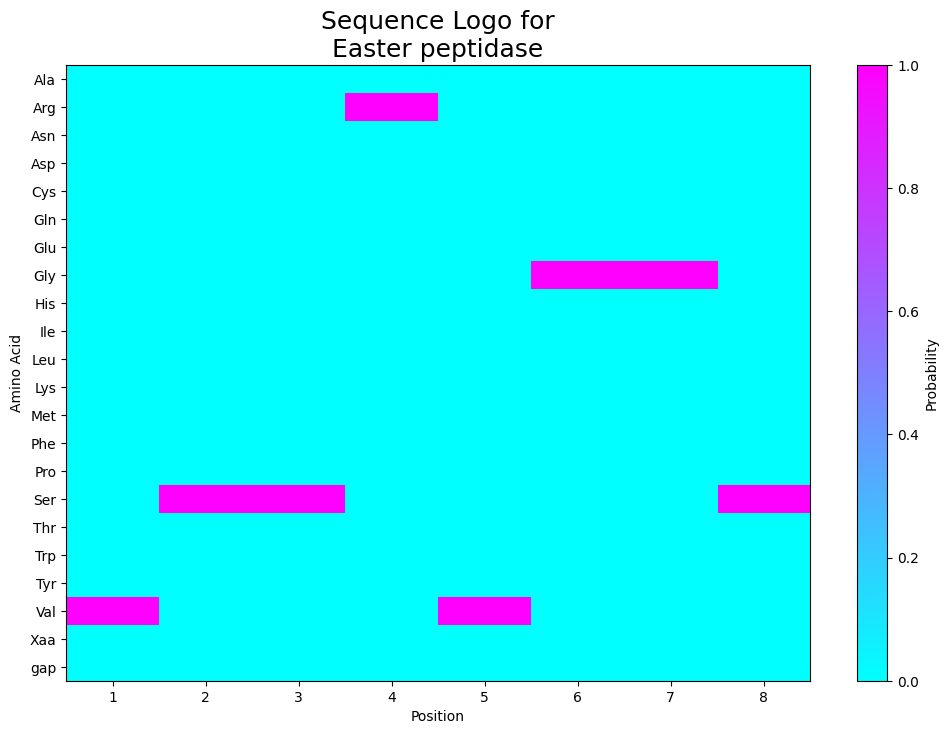

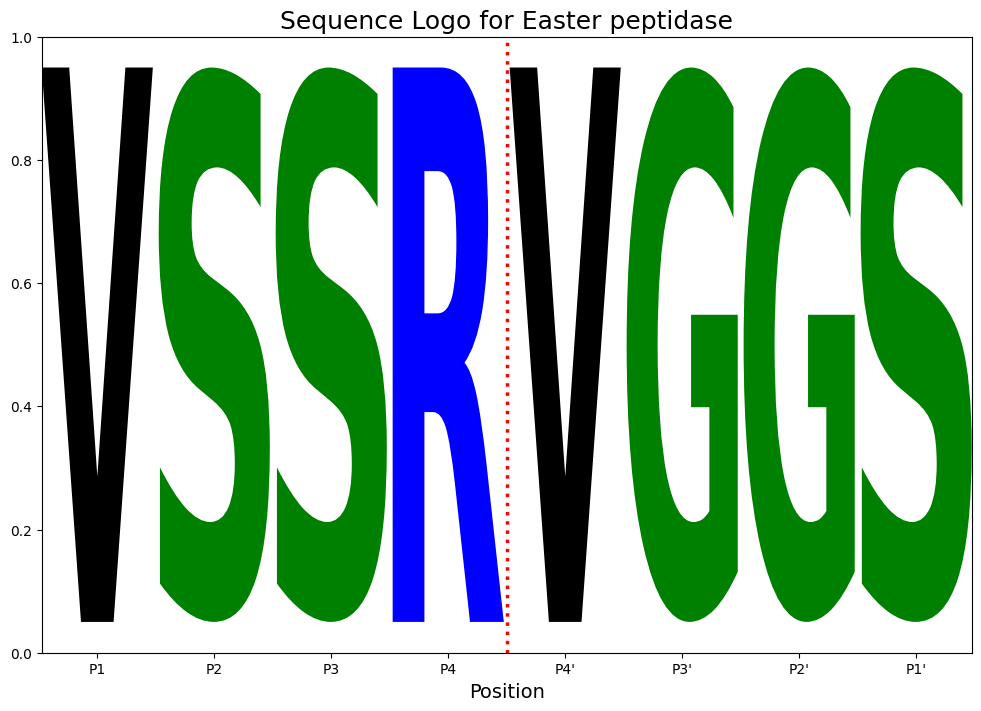

In [4]:
################ define ################
protease_name = "Easter"
matrix = ppm_data
########################################

find_and_plot(protease_name, matrix)

The protease 'Spatzle-processing enzyme ({Drosophila} sp.)' has 1 substrates


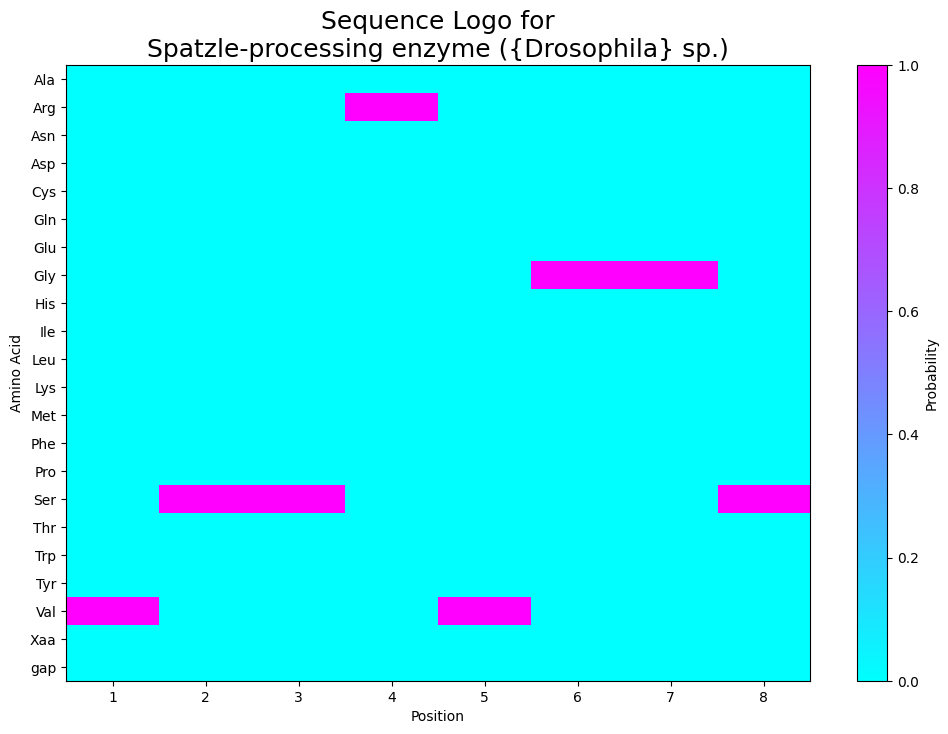

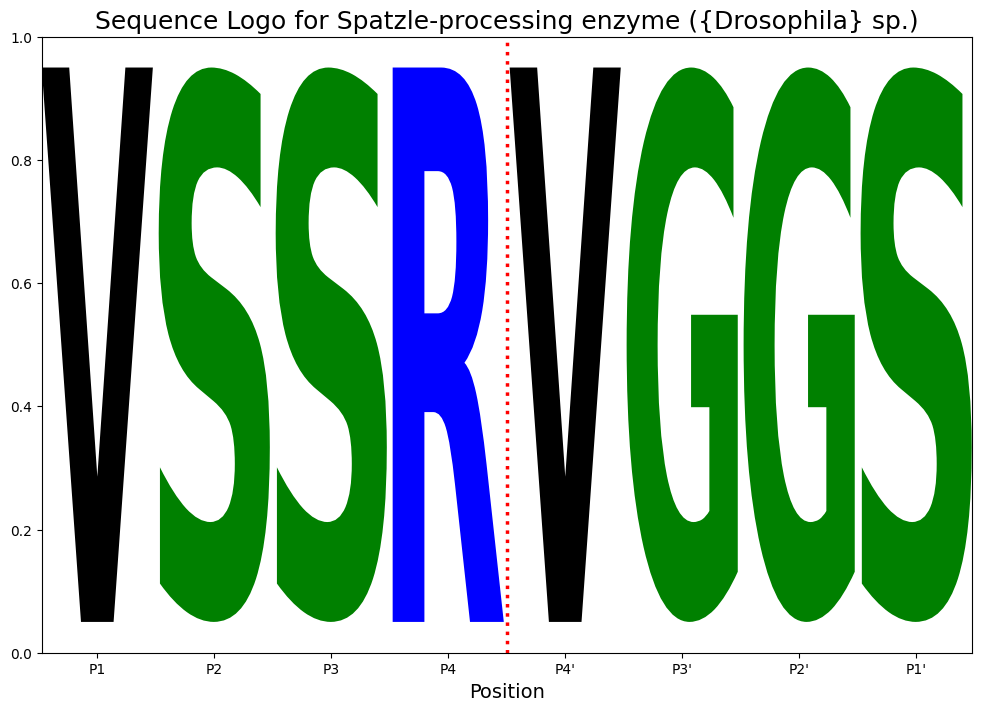

In [5]:
################ define ################
protease_name = "Spatzle"
matrix = ppm_data
########################################

find_and_plot(protease_name, matrix)

Another check can be performed with a lower threshold, allowing for less specific proteases to be included.

- set `threshold = 0.6` in `sub-cut.py`
- add the sequences in `target_peptides.fasta`
- run the program `python3 sub-cut.py`

This time, a protease with a score of **28**, [EspL g.p. ({Escherichia coli})](https://www.ebi.ac.uk/merops/cgi-bin/pepsum?id=C118.001), with this alignment:
```ali
target            2 VGGNYNYL 10
                  0 ||.|-|||  8
query             0 VGDN-NYL  7
```

The protease 'EspL g.p. ({Escherichia coli})' has 2 substrates


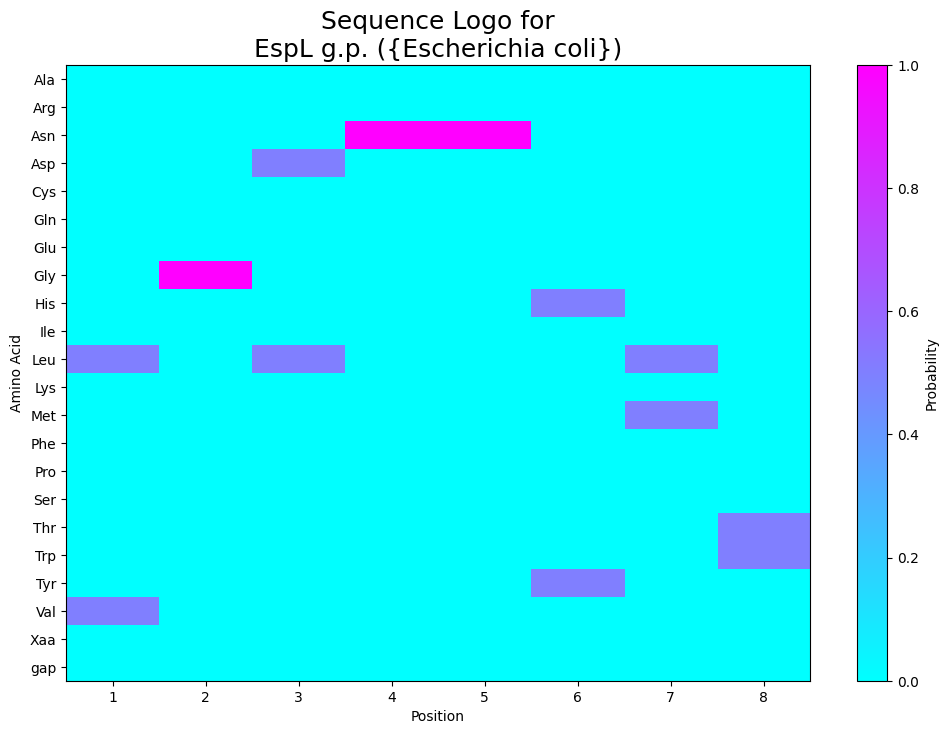

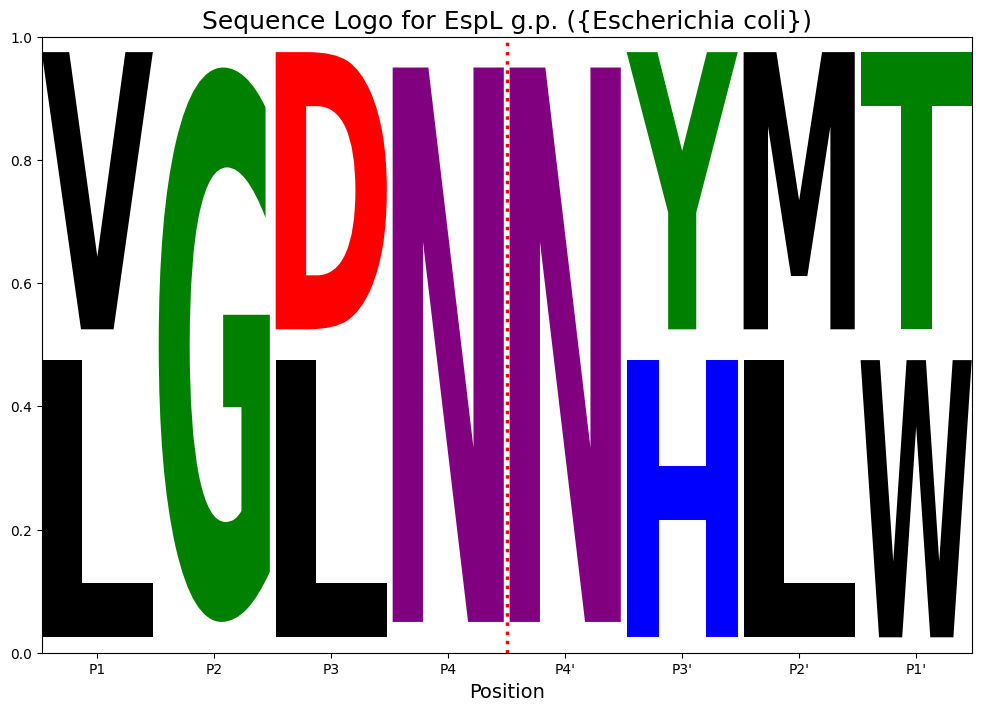

In [6]:
################ define ################
protease_name = "EspL g.p. ({Escherichia coli})"
matrix = ppm_data
########################################

find_and_plot(protease_name, matrix)